In [1]:
import astropy
from astroquery.simbad import Simbad

In [2]:
# Dependencies 
# astroquery

In [3]:
Simbad.query_objectids('NQ Dra', cache=False)

ID
bytes29
TIC 359678119
V* NQ Dra
2MASS J18441316+5740594
GSC 03926-00508
NSV 11317
NSVS 3043060
SV* SON 9663
UCAC3 296-130079
Gaia DR2 2154100169676165120


In [4]:
Object_name = "NQ Dra"
list_id = Simbad.query_objectids(Object_name, cache=False)

In [5]:
for i in list_id['ID']:
    if i[0:8] == "Gaia DR2":
        print (i)
        print (i[5:])

Gaia DR2 2154100169676165120
DR2 2154100169676165120


In [6]:
def gaia_id(Obj_name):
    """ Returns Gaia id for objects available in SIMBAD"""
    list_id = Simbad.query_objectids(Obj_name, cache=False)
    for i in list_id['ID']:
        if i[0:8] == "Gaia DR2":
            print (i)
            gaia_id = i
    return gaia_id[5:].split()[1]

gaia_id = gaia_id("NQ Dra")
#gaia_id=id.split()[1]

Gaia DR2 2154100169676165120


In [7]:
from astroquery.gaia import Gaia
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os

Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [21]:
def fetch_lightcurve_dr2(gaia_id, output_dir='../data/'):
    """ Fetch Gaia Lightcurve for a Gaia Source ID (of a variable star) from Gaia DR2 Data Link
    
    Returns path of csv file stored for given source
    
    Args:
        gaia_id (string): String. Gaia Source ID of the variable star you need to fetch the lightcurve from DR1 for
        [output_dir] (string): Optional. String. By default, the csv files for the lightcurves are stored in the subfolder data/. To change the default path, enter a new path for the folder to save the lightcurve

    Returns:
        String. Gives back the path/to/lightcurve/filename.csv where the lightcurve is stored
    """
    url='https://gea.esac.esa.int/data-server/data?ID=Gaia+DR2+'+gaia_id+'&RETRIEVAL_TYPE=EPOCH_PHOTOMETRY&FORMAT=CSV'
    save_path=output_dir+gaia_id+'_data.csv'
    read_data = requests.get(url, allow_redirects=True)
    assert len(read_data.content)!=0, 'Could not fetch lightcurve from DR2 for Gaia Source ID '+gaia_id
    open(save_path, 'wb').write(read_data.content)
    return save_path

In [23]:
sp=fetch_lightcurve_dr2('2154100169676165120')

In [25]:
lc=pd.read_csv(sp)
print(len(lc))

84


In [32]:
def fetch_lightcurve_dr1(gaia_id, output_dir='../data/'):
    """ Fetch Gaia Lightcurve for a Gaia Source ID (of a variable star) from Gaia DR1 Data Link
    
    Returns path of csv file stored for given source
    
    Args:
        gaia_id (string): String. Gaia Source ID of the variable star you need to fetch the lightcurve from DR1 for
        [output_dir] (string): Optional. String. By default, the csv files for the lightcurves are stored in the subfolder data/. To change the default path, enter a new path for the folder to save the lightcurve

    Returns:
        String. Gives back the path/to/lightcurve/filename.csv where the lightcurve is stored
    """
    save_path=output_dir+gaia_id+'_data.csv'
    query = 'select solution_id, source_id, observation_time, g_flux, g_flux_error, g_magnitude, \
            2.5/log(10)* g_flux_error/ g_flux AS g_magnitude_error, rejected_by_variability_processing AS rejected \
            FROM gaiadr1.phot_variable_time_series_gfov \
            WHERE source_id='+ gaia_id
    dr1_job = Gaia.launch_job_async(query, output_file=save_path, output_format='csv', dump_to_file=True)
    print('Loading DR1 lightcurve')
    while(dr1_job.is_finished()!=True):
        pass
    if(len(dr1_job.get_results())==0):
        os.remove(save_path)
    assert len(dr1_job.get_results())!=0, 'Could not fetch lightcurve from DR1 for Gaia Source ID '+gaia_id
    print('Loaded DR1 lightcurve')
    return save_path

In [33]:
sp2=fetch_lightcurve_dr1('5284240582308398080')

Saving results to: ../data/5284240582308398080_data.csv
Loading DR1 lightcurve
Loaded DR1 lightcurve


In [31]:
lc2=pd.read_csv(sp2)
print(len(lc2))

144


In [154]:
?Gaia.launch_job_async

Signature:
Gaia.launch_job_async(
    query,
    name=None,
    output_file=None,
    output_format='votable',
    verbose=False,
    dump_to_file=False,
    background=False,
    upload_resource=None,
    upload_table_name=None,
    autorun=True,
)
Docstring:
Launches an asynchronous job

Parameters
----------
query : str, mandatory
    query to be executed
output_file : str, optional, default None
    file name where the results are saved if dumpToFile is True.
    If this parameter is not provided, the jobid is used instead
output_format : str, optional, default 'votable'
    results format. Available formats are: 'votable', 'votable_plain',
     'fits', 'csv' and 'json', default is 'votable'.
     Returned results for 'votable' and 'fits' formats are compressed
     gzip files.
verbose : bool, optional, default 'False'
    flag to display information about the process
dump_to_file : bool, optional, default 'False'
    if True, the results are saved in a file instead of using memory

In [93]:
#Not required - Only for launching the job
job = Gaia.launch_job_async("SELECT  source_id, phot_variable_flag, datalink_url \
from gaiadr2.gaia_source \
where source_id in ("+ gaia_id +") \
and phot_variable_flag = 'VARIABLE';"
, output_file='data/' + gaia_id + '.csv', output_format='csv', verbose=False, dump_to_file=True)

Saving results to: data/3373085521202437632.csv


In [98]:
#Not Required
url_csv=pd.read_csv('data/3373085521202437632.csv')
url_1=url_csv['datalink_url'][0]
print(url_1)
#####


###Required
url='https://gea.esac.esa.int/data-server/data?ID=Gaia+DR2+'+gaia_id+'&RETRIEVAL_TYPE=EPOCH_PHOTOMETRY&FORMAT=CSV'
print(url)
#######



# https://gea.esac.esa.int/data-server/datalink/links?ID=Gaia+DR2+3373085521202437632
# 'https://gea.esac.esa.int/data-server/data?ID=Gaia+DR2+3373085521202437632&RETRIEVAL_TYPE=EPOCH_PHOTOMETRY&FORMAT=CSV'

https://gea.esac.esa.int/data-server/datalink/links?ID=Gaia+DR2+3373085521202437632
https://gea.esac.esa.int/data-server/data?ID=Gaia+DR2+3373085521202437632&RETRIEVAL_TYPE=EPOCH_PHOTOMETRY&FORMAT=CSV


In [102]:
##Required - Download the csv having the lightcurve
r = requests.get(url, allow_redirects=True)
open('data/'+gaia_id+'_data.csv', 'wb').write(r.content)

8997

In [25]:
##Required- Reading the csv
lk=pd.read_csv('data/'+gaia_id+'_data.csv')
lk.head()

,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
0,2154100169676165120,18666194224435768,G,1734.412904,13.324313,88230.945137,77.074133,1144.7543,False,False,1,369295549951641967
1,2154100169676165120,22203014443966549,G,1798.373397,13.311913,89244.437629,77.825476,1146.7252,False,False,1,369295549951641967
2,2154100169676165120,22207106732717605,G,1798.447403,13.475483,76763.178101,86.551529,886.9072,False,False,4097,369295549951641967
3,2154100169676165120,23961832881841052,G,1830.180392,13.406898,81768.680744,156.733415,521.7055,False,False,4097,369295549951641967
4,2154100169676165120,25712596649916223,G,1861.842019,13.360012,85377.150741,64.099766,1331.9417,False,False,1,369295549951641967


Text(0, 0.5, 'Flux')

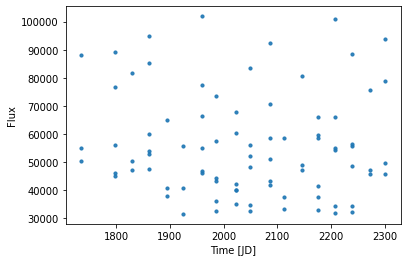

In [26]:
##Required- Plotting a scatter plot
fig = plt.figure()
plt.scatter(lk.time, lk.flux, alpha=0.9, s=10)
plt.xlabel("Time [JD]")
plt.ylabel("Flux")
#plt.title("light curve for DR1 Source", lk.source_id)

In [45]:
##Fetching from DR1 (hardcoded)
dr1_job = Gaia.launch_job_async("SELECT curves.observation_time, \
  mod(curves.observation_time - rrlyrae.epoch_g, rrlyrae.p1)/ rrlyrae.p1 as phase, \
  curves.g_magnitude, 2.5/log(10)* curves.g_flux_error/ curves.g_flux AS g_magnitude_error, \
  rejected_by_variability_processing AS rejected \
FROM gaiadr1.phot_variable_time_series_gfov AS curves \
INNER JOIN gaiadr1.rrlyrae AS rrlyrae \
  ON rrlyrae.source_id = curves.source_id \
WHERE rrlyrae.source_id = 5284240582308398080",
output_file='data/DR1_5284240582308398080.csv', output_format='csv', verbose=False, dump_to_file=True)

Launched query: 'SELECT curves.observation_time,   mod(curves.observation_time - rrlyrae.epoch_g, rrlyrae.p1)/ rrlyrae.p1 as phase,   curves.g_magnitude, 2.5/log(10)* curves.g_flux_error/ curves.g_flux AS g_magnitude_error,   rejected_by_variability_processing AS rejected FROM gaiadr1.phot_variable_time_series_gfov AS curves INNER JOIN gaiadr1.rrlyrae AS rrlyrae   ON rrlyrae.source_id = curves.source_id WHERE rrlyrae.source_id = 5284240582308398080'
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/async
Content-type = application/x-www-form-urlencoded
303 303
[('Date', 'Thu, 24 Jun 2021 07:54:02 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips PHP/5.4.16 mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=block'), ('X-Frame-Options', 'SAMEORIGIN'), ('X-Content-Type-Options', 'nosniff'), ('Set-Cookie', 'JSESSIONID=F21907E4378B826855C9FEE696083739; Path=

In [111]:
lk_dr1=pd.read_csv('data/5284240582308398080_data.csv')
lk_dr1.head()

,solution_id,source_id,observation_time,g_flux,g_flux_error,g_magnitude,g_magnitude_error,rejected
0,374678695396246029,5284240582308398080,1666.476607,577.015351,8.587476,18.621802,0.016159,False
1,374678695396246029,5284240582308398080,1666.652765,421.630940,3.842789,18.962439,0.009896,False
2,374678695396246029,5284240582308398080,1666.726771,391.224641,3.927841,19.043705,0.010901,False
3,374678695396246029,5284240582308398080,1666.902929,341.913971,3.226828,19.189978,0.010247,False
4,374678695396246029,5284240582308398080,1666.976936,773.497762,7.334110,18.303622,0.010295,False


Text(0.5, 1.0, 'light curve for DR1 Source 5284240582308398080')

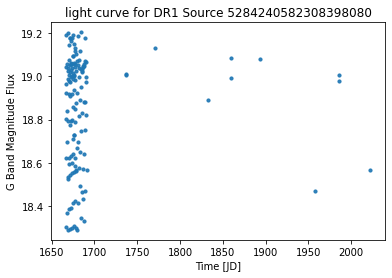

In [112]:
fig = plt.figure()
plt.scatter(lk_dr1.observation_time, lk_dr1.g_magnitude, alpha=0.9, s=10)
plt.xlabel("Time [JD]")
plt.ylabel("G Band Magnitude Flux")
plt.title("light curve for DR1 Source 5284240582308398080", )

/home/kukretianiket/miniconda3/envs/codeastro/lib/python3.9/site-packages/astropy/table/table.py:3197: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
Saving results to: ../data/5284240582308398080_data_dr1.csv
Loading DR1 lightcurve
Loaded DR1 lightcurve


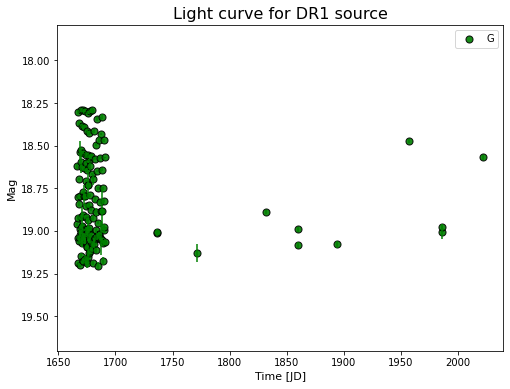

In [58]:
from astroquery import gaia
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
import math as m
import requests
import matplotlib.pyplot as plt
import os
import pandas as pd

def gaia_id(obj_name):
    """ Get Gaia ID for an object
    
    Returns Gaia id for objects available in SIMBAD
    
    Args:
        obj_name (string): String. Reference name of objects available in the SIMBAD catalog that we need the Gaia ID for.

    Returns:
        String. Gives back the Gaia ID of the object. Returns empty string if Gaia ID could not be fetched.
    """
    list_id = Simbad.query_objectids(obj_name, cache=False)
    if list_id == None:
        print('Gaia ID not found for given object')
        return ''
    for i in list_id['ID']:
        if i[0:8] == "Gaia DR2":
            gaia_id = i
    return gaia_id[5:].split()[1]

def fetch_lightcurve_dr2(gaia_id, output_dir='../data/'):
    """ Fetch Gaia Lightcurve for a Gaia Source ID (of a variable star) from Gaia DR2 Data Link
    
    Returns path of csv file stored for given source
    
    Args:
        gaia_id (string): String. Gaia Source ID of the variable star you need to fetch the lightcurve from DR1 for
        [output_dir] (string): Optional. String. By default, the csv files for the lightcurves are stored in the subfolder data/. To change the default path, enter a new path for the folder to save the lightcurve

    Returns:
        String. Gives back the path/to/lightcurve/filename.csv where the lightcurve is stored. Returns empty string if no lightcurve is fetched.
    """
    url='https://gea.esac.esa.int/data-server/data?ID=Gaia+DR2+'+gaia_id+'&RETRIEVAL_TYPE=EPOCH_PHOTOMETRY&FORMAT=CSV'
    save_path=output_dir+gaia_id+'_data_dr2.csv'
    read_data = requests.get(url, allow_redirects=True)
    if(len(read_data.content)==0):
        print('Could not fetch lightcurve from DR2 for Gaia Source ID '+gaia_id)
        return '' 
    #assert len(read_data.content)!=0, 'Could not fetch lightcurve from DR2 for Gaia Source ID '+gaia_id
    if not os.path.exists(output_dir):
        os.makedirs(output_dir) 
    open(save_path, 'wb').write(read_data.content)
    return save_path


def fetch_lightcurve_dr1(gaia_id, output_dir='../data/'):
    """ Fetch Gaia Lightcurve for a Gaia Source ID (of a variable star) from Gaia DR1 Data Link
    
    Returns path of csv file stored for given source
    
    Args:
        gaia_id (string): String. Gaia Source ID of the variable star you need to fetch the lightcurve from DR1 for
        [output_dir] (string): Optional. String. By default, the csv files for the lightcurves are stored in the subfolder data/. To change the default path, enter a new path for the folder to save the lightcurve

    Returns:
        String. Gives back the path/to/lightcurve/filename.csv where the lightcurve is stored. Returns empty string if no lightcurve is fetched.
    """
    save_path=output_dir+gaia_id+'_data_dr1.csv'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir) 
    query = 'select solution_id, source_id, observation_time, g_flux, g_flux_error, g_magnitude, \
            2.5/log(10)* g_flux_error/ g_flux AS g_magnitude_error, rejected_by_variability_processing AS rejected \
            FROM gaiadr1.phot_variable_time_series_gfov \
            WHERE source_id='+ gaia_id
    dr1_job = Gaia.launch_job_async(query, output_file=save_path, output_format='csv', dump_to_file=True)
    print('Loading DR1 lightcurve')
    while(dr1_job.is_finished()!=True):
        pass
    if(len(dr1_job.get_results())==0):
        os.remove(save_path)
        print('Could not fetch lightcurve from DR1 for Gaia Source ID '+gaia_id)
        return ''    
    #assert len(dr1_job.get_results())!=0, 'Could not fetch lightcurve from DR1 for Gaia Source ID '+gaia_id
    print('Loaded DR1 lightcurve')
    return save_path

def plot_lightcurve(csv_path):
    """ Plot Gaia Lightcurve for a given .csv file obtained from fetch_lightcurve_dr1 or fetch_lightcurve_dr2.
    
    Returns 
    
    Args:
        csv_path (string): String. Path to the generated .csv file

    Returns:
        
    """
    df = pd.read_csv(csv_path)

    if csv_path.endswith('dr1.csv'):
        y_upper = df.g_magnitude.max()
        y_lower = df.g_magnitude.min()
        
        plt.figure(1, (8, 6))
        plt.scatter(df.observation_time, df.g_magnitude, s=50, c='green', edgecolors='black', alpha=0.9, label='G')
        plt.errorbar(df.observation_time, df.g_magnitude, df.g_magnitude_error, c='green', ls='')
        plt.legend()
        plt.ylim(y_lower-0.5, y_upper+0.5)
        plt.gca().invert_yaxis()
        plt.xlabel("Observation Time [Barycentric JD in TCB - 2455197.5 (day)]", size=11)
        plt.ylabel("Mag", size=11)
        plt.title(r'Light curve for DR1 source', size=16)
        plt.show()

    elif csv_path.endswith('dr2.csv'):
        df_G = df.loc[df['band'] == 'G']
        df_BP = df.loc[df['band'] == 'BP']
        df_RP = df.loc[df['band'] == 'RP']

        y_upper = max(df_G.mag.max(), df_BP.mag.max(), df_RP.mag.max())
        y_lower = min(df_G.mag.min(), df_BP.mag.min(), df_RP.mag.min())

        plt.figure(1, (8, 6))
        plt.scatter(df_G.time, df_G.mag, s=50, c='green', edgecolors='black', alpha=0.9, label='G')
        plt.plot(df_G.time, df_G.mag, c='green', lw=0.1)
        plt.scatter(df_BP.time, df_BP.mag, s=50, c='blue', edgecolors='black', alpha=0.9, label='BP')
        plt.plot(df_BP.time, df_BP.mag, c='blue', lw=0.1)
        plt.scatter(df_RP.time, df_RP.mag, s=50, c='red', edgecolors='black', alpha=0.9, label='RP')
        plt.plot(df_RP.time, df_RP.mag, c='red', lw=0.1)
        plt.legend()
        plt.ylim(y_lower-0.5, y_upper+0.5)
        plt.gca().invert_yaxis()
        plt.xlabel("Time [Barycentric JD in TCB - 2455197.5 (day)]", size=11)
        plt.ylabel("Mag", size=11)
        plt.title(r'Light curve for DR2 source', size=16)
        plt.show()

    else:
        print('Valid .csv not found.')

gid = gaia_id('Nq Dra')
csv_path = fetch_lightcurve_dr1('5284240582308398080')
#csv_path = fetch_lightcurve_dr2(gid)
plot_lightcurve(csv_path)